In [246]:
import argparse

from utils.io_utils import (
    load_input_paths, 
    load_config, 
    load_panel, 
    load_image, 
    load_mask_generation_panel,
    save_tissue_mask,
    save_mask_metadata,
    save_mask_qc
)
from utils.mask_utils import (
    determine_gmm_tissue_threshold, 
    determine_otsu_tissue_threshold, 
    generate_tissue_mask,
    generate_mask_qc_plot
)
from utils.preprocessing import preprocess_image

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Mimic the command-line arguments
args = argparse.Namespace(
    config = 'config.yaml',
    threshold_method = 'gmm',
    remove_small_objects = True,
    fill_small_holes = True,
    save_metadata = True,
    save_qc = True,
    preprocess_images = True
)

PosixPath('datasets/input/1085471.mcd')

In [247]:
# Initialize the environment and parse user configurations
# args = parse_arguments()
config = load_config(args.config)
img_files, file_type = load_input_paths(config)
panel = load_panel(img_files[0], file_type, config)

In [248]:
# Fetch mask generation markers if provided
mask_panel = load_mask_generation_panel(config, panel)
mask_metals = mask_panel['canonical_metal_tag'].tolist()

In [261]:
path = img_files[0]
image_name = path.name

# Load the image
image = load_image(path, file_type, panel)

# Filter for markers used for mask generation
composite = image.sel(channel = image['metal_tag'].isin(mask_metals))

# Preprocess the image if toggled
if args.preprocess_images:
    composite = preprocess_image(composite, config)

In [262]:
# Dynamically generate a tissue threshold for the image: GMM or Otsu's
if args.threshold_method == 'otsu':
    threshold, threshold_metadata  = determine_otsu_tissue_threshold(
        composite, config
    )
else:
    threshold, threshold_metadata = determine_gmm_tissue_threshold(
        composite, config
    )

In [280]:
threshold, threshold_metadata  = determine_otsu_tissue_threshold(
    composite, config
)

In [281]:
# Generate a tissue mask using the threshold
mask, mask_metadata = generate_tissue_mask(
    composite, threshold, args.remove_small_objects, 
    args.fill_small_holes, config
)

In [282]:
# Save the mask as the image's filename with '_mask.tiff' suffix
save_tissue_mask(mask, image_name, config)

In [283]:
# Save the mask generation metadata if toggled
if args.save_metadata:
    metadata = {**threshold_metadata, **mask_metadata}
    save_mask_metadata(metadata, image_name, config)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

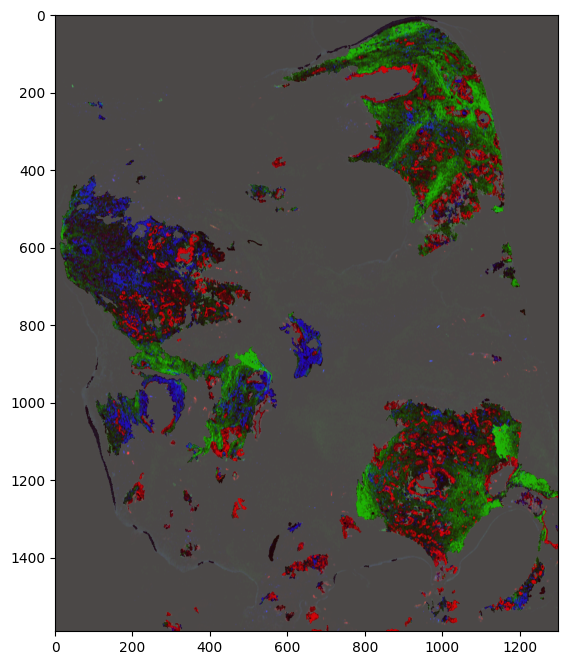

In [284]:
# Generate and save a quality control (QC) plot if toggled
if args.save_qc:
    qc_plot = generate_mask_qc_plot(
        mask, composite, image_name, mask_panel,
        threshold_metadata, mask_metadata, config
    )
    save_mask_qc(qc_plot, image_name, config)